<h1 align="center">Разведочный анализ тренировочного набора данных</h1>

Импортируем необходимый функционал

In [1]:
import gc
import re
import json
from enum import Enum
from tqdm import tqdm
from sys import getsizeof

import polars
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import chisquare, tukey_hsd
from langdetect import detect, detect_langs, DetectorFactory

tqdm.pandas()

Данные представлены в формате jsonl. Нашей команде превычнее и удобнее работать с табличной формацией данных. Поэтому зашрузим данные в формате jsonl и преобразуем их в табличную формацию

In [2]:
df = pd.read_json("data/ranking_train.jsonl", lines = True)
print(df.shape)
print(f"[memory usage]: {round(getsizeof(df) / 1024 ** 2, 3)} Mb")

(88107, 2)
[memory usage]: 18.458 Mb


In [3]:
text = []
comments = []
for data in tqdm(df.iterrows()):
    tmp = [data[1]["text"]] * 5
    text += tmp
    for comment in data[1]["comments"]:
        comments.append(comment["text"])
        
assert len(text) == (df.shape[0] * 5)
assert len(comments) == (df.shape[0] * 5)

scores = [0, 1, 2, 3, 4] * df.shape[0]

train = pd.DataFrame(columns=["text", "comments", "score"])
train["text"] = text
train["comments"] = comments
train["score"] = scores

del text, comments, scores, df
gc.collect();

88107it [00:03, 27616.16it/s]


По умолчанию в pandas целые значения кастуются к типу int64. Однако, для столбца "score" - это избыточно. Можем ограничиться 8-битным беззнаковым целочисленным типом

In [4]:
train["score"] = train["score"].astype(np.uint8)

Оценим рзамерность, потребление памяти и сэмплируем 5 случайных наблюдений из тренировочной выборки

In [5]:
print(train.shape)
print(f"[memory usage]: {round(getsizeof(train) / 1024 ** 2, 3)} Mb")
train.sample(5)

(440535, 3)
[memory usage]: 307.128 Mb


,text,comments,score
393804,Credit Card Breach at California DMV,I heard a commercial for Lifelock the other da...,4
425590,“Mostly functional” programming does not work,To play devil&#x27;s advocate for a minute:Nea...,0
428998,Go 1.4+ Garbage Collection Plan and Roadmap,Seems like the 10ms pause thing provokes a muc...,3
367055,South Africa's Nelson Mandela dies,Mandela reminds us that it&#x27;s possible for...,0
329951,Nate Silver Went Against the Grain for Some at...,I was skeptical when Nate Silver first got pic...,1


Использование памяти выросло почти в 18 раз. Чтобы сократить расход памяти, можно использовать фреймворк polars

In [6]:
round(polars.from_pandas(train).estimated_size("mb"), 3)

246.38

Использование polars выгоднее по памяти, нежели использование pandas.  
Однако, для EDA будем использовать pandas, т.к. API pandas, пока что, ещё обширнее, чем API polars

Проверим табличку на отсутствие пропусков

In [7]:
train.isna().sum()

text        0
comments    0
score       0
dtype: int64

Пропусков в данных нет

Оценим, имеются ли в данные дубликаты

In [8]:
train.duplicated().sum()

0

"Чистых" дубликатов, т.е. таких, которые бы полностью совпадали по всему признаковому описанию, нет

Оценим уникальное кол-во значений по полям "text" и "comments"

In [9]:
train[["text", "comments"]].nunique()

text         87664
comments    440525
dtype: int64

Значит, в имеются посты, схожие между собой. Это означает, что как лексикографический порядок следования символов, так и семантическая подоплёка, полностью совпадают

Посмотрим, что это за тексты постов

In [10]:
(train["text"].value_counts() / 5).to_frame().head(10)

,text
Facebook is down,7.0
Ask HN: Idea Sunday,6.0
Ask HN: Who's Hiring?,5.0
Ask HN: What are you working on?,5.0
Ask HN: Can I help you be more awesome today? (No strings. Inquire within.),4.0
Ask HN: Review my startup,4.0
Github is down,4.0
Ask HN: Can I help you be more awesome today? (No strings.),4.0
Myths About Introverts,3.0
Happy Pi Day,3.0


Глянем теперь тоже самое, но уже для комментариев постов

In [11]:
train["comments"].value_counts().to_frame().head(7)

,comments
Google cache: http://webcache.googleusercontent.com/search?q=cache:http://...,4
http:&#x2F;&#x2F;webcache.googleusercontent.com&#x2F;search?q=cache:http:&#x2F;&#x2F;...,4
http:&#x2F;&#x2F;www.reddit.com&#x2F;r&#x2F;programming,2
"Even though Steam invites its own problems (it's ultimately a form of DRM, a closed platform, and a closed-source application), as a FOSS developer I can't help but feel excited about this prospect. I know many, many people in the 15-35 age bracket who are open to and curious about Linux, even tried it, but ultimately didn't stick with it because of the lack of high-end native games and because rebooting or setting up Wine is too much of a hassle. Valve has tremendous power to change this and legitimize Linux as a platform in their eyes.Plus, there's already a lot of games in the Steam catalogue that have native Linux versions available:- Dozens of independent titles, e.g. everything that was in those Humble Bundles.- Everything using the DOSBox emulator to run even on Windows, e.g. id's Commander Keen, some Lucasarts Star Wars games, etc.- Even a bunch of AAA titles: id Software's games (Doom, Quake) and games that have licensed their engine (e.g. Human Head's Prey), games that were ported by Linux Game Publishing (e.g. Egosoft's X series of spaceflight simulators), several games by Epic (e.g. Unreal Tournament) or using an Epic engine (e.g. Rune and Deus Ex, ported by Loki), Neverwinter Nights, Civilization: Call to Power, ...Add Valve's own games and possibly some of the other games using their Source engine, and you could easily make 100-150 games available on Linux within a year of launch just from what's already there. But even more exciting is the notion of Steam's availability making more game makers consider adding Linux to their list of supported platforms going forward because the distribution problem is solved for them.",2
Paywall-less Google link to article: http://www.google.com/url?sa=t&#38;rct=j&#38;q=&#38;esrc=s&#...,2
"From the guidelines:If the original title begins with a number or number + gratuitous adjective, we'd appreciate it if you'd crop it. E.g. translate ""10 Ways To Do X"" to ""How To Do X,"" and ""14 Amazing Ys"" to ""Ys."" Exception: when the number is meaningful, e.g. ""The 5 Platonic Solids.""",2
"Sandboxing is utterly broken. If you want a real hellride try to load 'sandbox unsafe' Audio Units (read: every non-Apple AU, though many Apple AUs aren't safe either) into a sandboxed application.There's a temporary entitlement that should allow this. The only problem is, that this entitlement simply disables sandboxing midway through app initialization and the NSUserDefaults system becomes unusable after that.See last post in: https://devforums.apple.com/thread/155950?tstart=0",1


Отсюда видно, что некоторые комментарии с точки зрения семантики "пустые", т.к. в большинстве своём содержат ссылки

Посмотрим, на ранги комментариев, в которых содеражатся ссылки

In [12]:
train["flag"] = train["comments"].progress_apply(
    lambda x: "http" in x
)

100%|██████████████████████████████████████████████████████████████████████| 440535/440535 [00:00<00:00, 871598.24it/s]


In [13]:
train[train["flag"] == True].shape[0]

94316

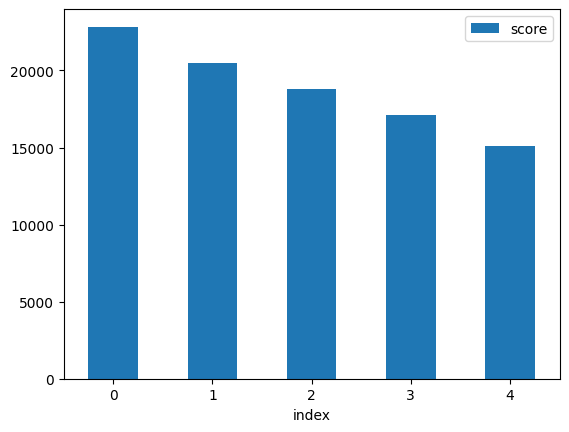

In [14]:
train[train["flag"] == True]["score"].value_counts().reset_index().plot.bar(x="index", y="score", rot=0);

Кажется, что ссылки равномерно присутствуют в каждом ранге. Проверим эту гипотезу с помощью критерия $\chi^2$

$H_0$: распределение рангов для комментариев, содержащих ссылку, подчиняется равномерному закону  
$H_1$: распределение не подчиняется равномерному закону

In [15]:
f_obs = pd.crosstab(train["flag"], train["score"]).reset_index().loc[1].values[1:]
f_exp = np.asarray([f_obs.sum() / 5] * 5)
chisquare(f_obs=f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=1885.118155986259, pvalue=0.0)

Отсюда можно сделать следующее заключение, что распределение рангов для комментариев, содержащих ссылку, не подчиняется равномерному закону распределения

Посчитаем вероятности встретить ссылку в комментарии для каждого рангов

In [16]:
shape = train.shape[0] // 5

for score in range(5):
    prob = round(train[((train["score"] == score) & (train["flag"] == True))].shape[0] / shape, 3)
    print(f"[score == {score}]: {prob}")

[score == 0]: 0.259
[score == 1]: 0.232
[score == 2]: 0.213
[score == 3]: 0.194
[score == 4]: 0.171


In [17]:
train.drop("flag", axis=1, inplace=True)

Посмотрим, на каких языках написаны посты

Для определения языка будем пользовать библиотекой langdetect. Для воспроизводимости зафиксируем сид

In [18]:
DetectorFactory.seed = 0

def detect_language(text: str) -> str:
    """
    Detects text language
    :text: initial text
    :returns: text language
    """
    try:
        ans = detect(text)
    except:
        ans = "unknown"
    return ans

In [19]:
train["text_lang"] = train["text"].progress_apply(detect_language)
train["comments_lang"] = train["comments"].progress_apply(detect_language)

100%|█████████████████████████████████████████████████████████████████████████| 440535/440535 [33:10<00:00, 221.32it/s]


Т.к. операция определения языка слишком затратная по времени, полученную табличку выгрузим в отдельный файл

In [20]:
train.to_csv("df_lang.csv", index=False)

In [21]:
print(f'Встречается {train["text_lang"].nunique()} разных языка, на которых написаны посты')
print(f'Для {len(train[train["text_lang"] == "unknown"])} постов не удалось определить язык')
print(f'На английском языке написано {round(train["text_lang"].value_counts()["en"] / len(train) * 100, 2)} % постов')

Встречается 34 разных языка, на которых написаны посты
Для 100 постов не удалось определить язык
На английском языке написано 91.17 % постов


Загрузим json с отображением сокращений в полные названия языков

In [22]:
with open("auxiliary_data/lang_map.json", "rb") as file:
    lang_translate = json.load(file)

Примением это отображение

In [23]:
train["text_lang"] = train["text_lang"].progress_apply(
    lambda x: lang_translate.get(x, -1)
)
train["comments_lang"] = train["comments_lang"].progress_apply(
    lambda x: lang_translate.get(x, -1)
)

100%|█████████████████████████████████████████████████████████████████████| 440535/440535 [00:00<00:00, 1158750.47it/s]


Посмотрим на распределение языков

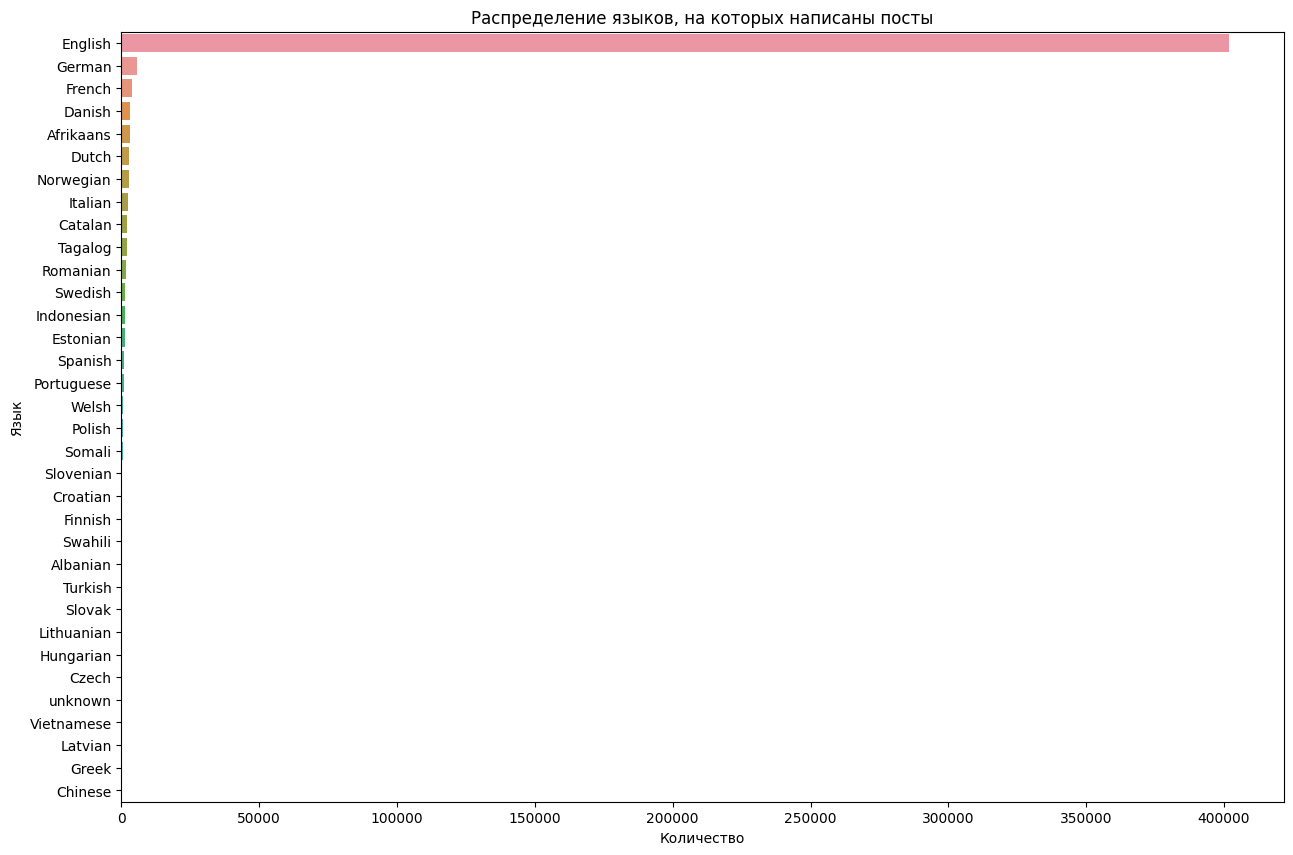

In [24]:
plt.figure(figsize = (15, 10))
(sns.countplot(data = train, y = "text_lang", order = train["text_lang"].value_counts().index)
 .set(xlabel="Количество", ylabel="Язык", title="Распределение языков, на которых написаны посты")
)
plt.show()

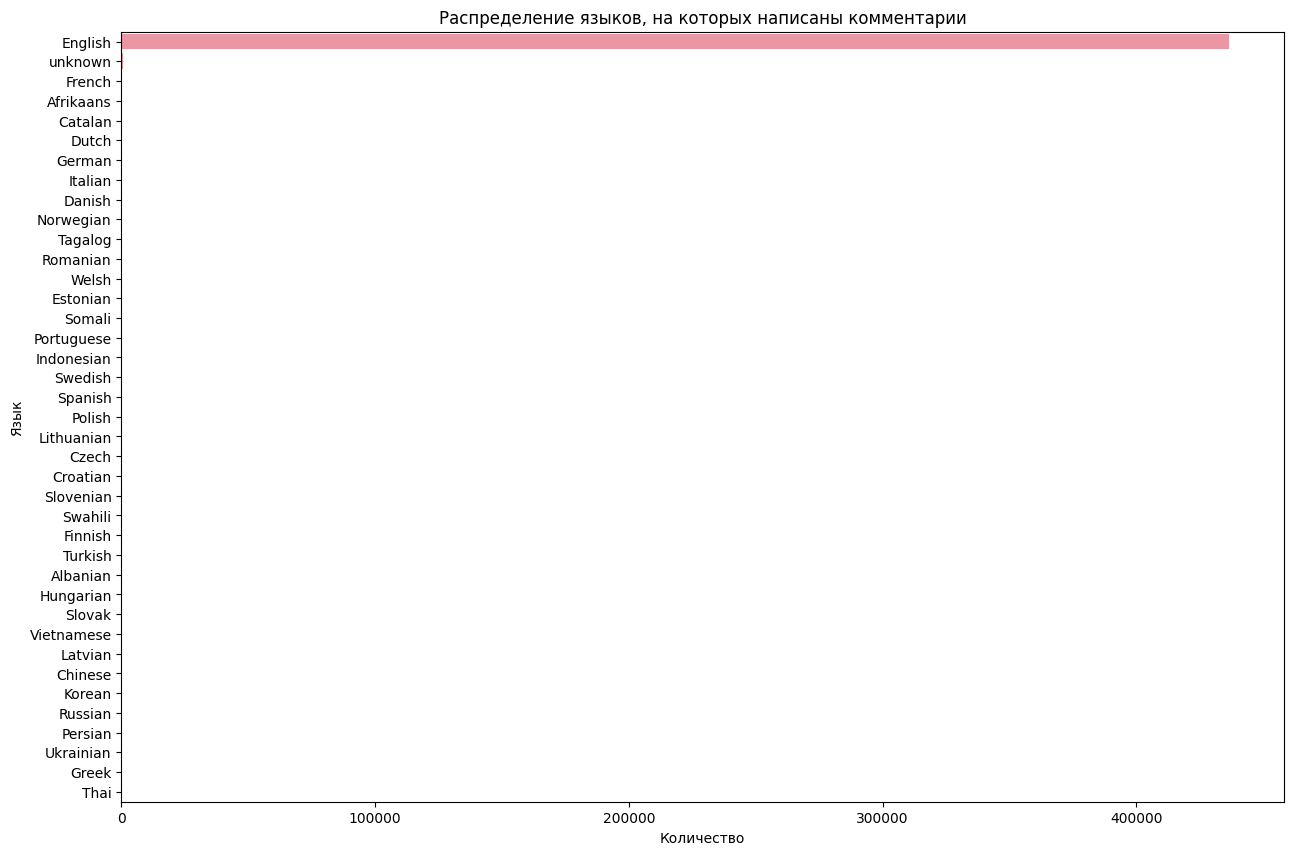

In [25]:
plt.figure(figsize = (15, 10))
(sns.countplot(data = train, y = "comments_lang", order = train["comments_lang"].value_counts().index)
 .set(xlabel="Количество", ylabel="Язык", title="Распределение языков, на которых написаны комментарии")
)
plt.show()

Из графиков видно, что львиная доля принадлежит английскому языку. Однако, слепо доверять результатам работы langdetect нельзя, т.к. из-за малого кол-ва слов или наличия "мусора" (смайлов, спец символов и т.д.), программного кода, только цифр и т.д., возможные с большой вероятности ошибки в детекции языка.

Здесь нас интересует категория "unknown" как для постов, так и для комментариев. Посмотри, какие тексты попали в эту категорию

In [26]:
train[train["text_lang"] == "unknown"]["text"].unique()

array(['01000111 01100101 01100101 01101011 00100000 01010111 01100001 01110100 01100011 01101000',
       'Yosemite@17gigapixels', '1975', '9,73,241,561,1081,1849,_?_',
       '2010 = 1+2-(3-4-5)*6*7*8-9', '0.30000000000000004',
       '-- --- •-• ••• • -•-• --- -•• • •• -• •--- •- •••- •- ••• -•-• •-• •• •--• -',
       '30/10/10', '2:40', '6÷2(1+2)=?', '42', '7373170279850', '☃',
       '1 + 2 + 3 + 4 + ... = - 1/12', '2048', '9007199254740992',
       '2(048)', '0^0', '276', '🌉'], dtype=object)

Очевидно, что это мусорные посты, которые проще всего удалить

In [27]:
train[train["comments_lang"] == "unknown"]["comments"].sample(10)

178987                          http://reddit.com/r/arduino
18120                                 http://startuply.com/
195699    http://en.wikipedia.org/wiki/Locality_of_refer...
8794                              http://igoogleforyou.com/
32516                              http://groupieguide.com/
97247                           http://www.workingpoint.com
306939                           http://simpledesktops.com/
148554                    http://learnpythonthehardway.org/
234650    http://net.tutsplus.com/tutorials/php/understa...
293152                          http://dotfiles.org/.bashrc
Name: comments, dtype: object

В комментариях можем наблюдать преимущественно ссылки, почтовые адреса, временные метки, смайлы (например, ;-)), даты, прсото цифы и т.д.  
Здесь самым простым решением также является удалить эти комментарии и сопряжённые с ними посты. Однако, в таком случае необходимо учитывать, какой объём выборки потеряем, проделав такую манипуляцию

Посмотрим на количество слов в постах и комментариях

In [28]:
def get_text_len(x: str) -> int:
    """
    Gets text length
    :x: initial text
    :returns: text length
    """
    return x.count(' ') + 1

In [29]:
train["text_len"] = train["text"].progress_apply(get_text_len)
train["comments_len"] = train["comments"].progress_apply(get_text_len)

100%|██████████████████████████████████████████████████████████████████████| 440535/440535 [00:00<00:00, 466007.33it/s]


Построим распределения текстов для постов и комментариев по кол-ву слов

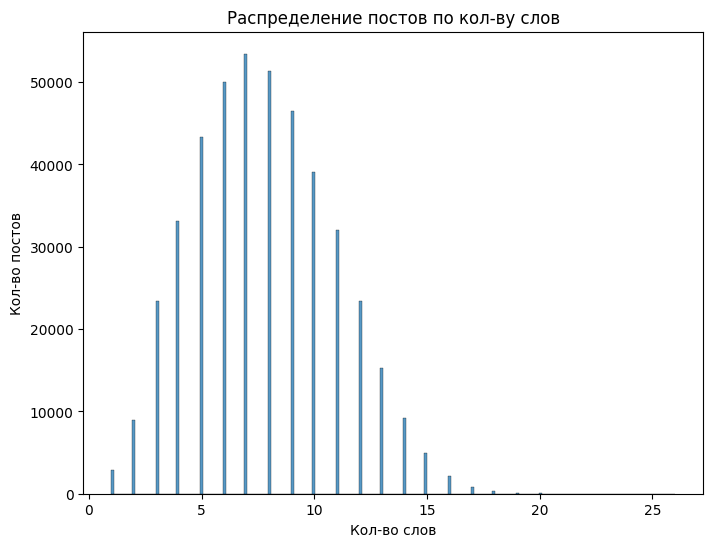

In [30]:
plt.figure(figsize = (8, 6))
(sns.histplot(train["text_len"])
 .set(title='Распределение постов по кол-ву слов', xlabel='Кол-во слов', ylabel='Кол-во постов')
)
plt.show()

Видно, что наиболее часто встречаются посты, в которых всего 7 слов

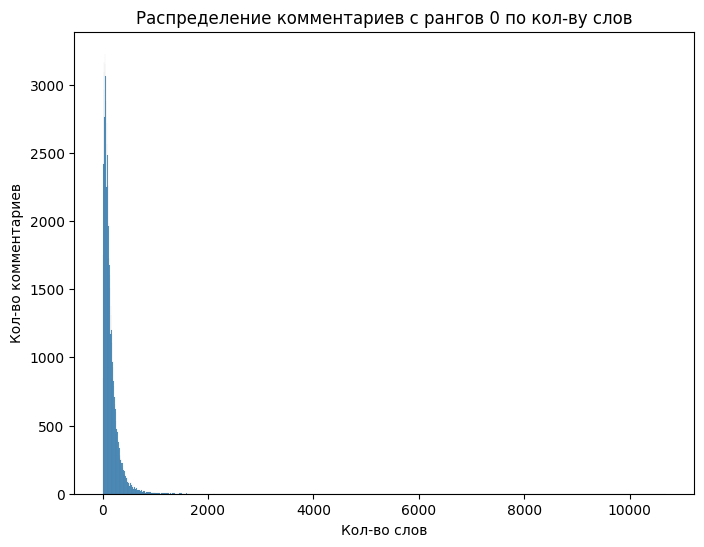

In [31]:
plt.figure(figsize = (8, 6))
(sns.histplot(train[train["score"] == 0]["comments_len"])
 .set(title='Распределение комментариев с рангов 0 по кол-ву слов', xlabel='Кол-во слов', ylabel='Кол-во комментариев')
)
plt.show()

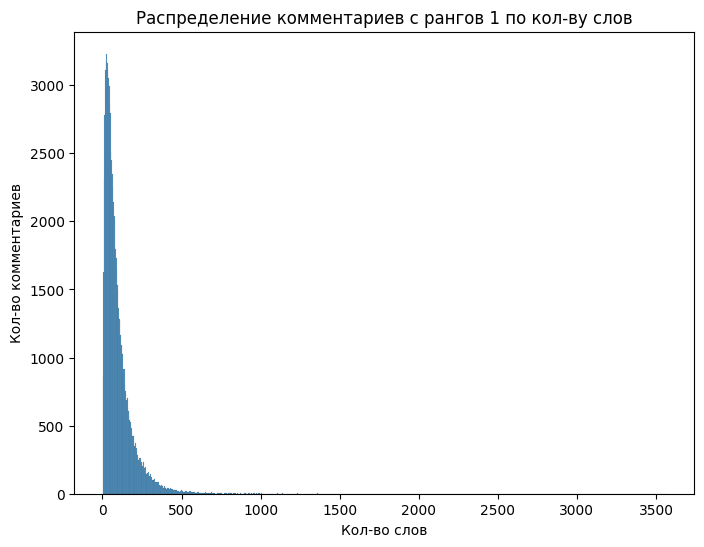

In [32]:
plt.figure(figsize = (8, 6))
(sns.histplot(train[train["score"] == 1]["comments_len"])
 .set(title='Распределение комментариев с рангов 1 по кол-ву слов', xlabel='Кол-во слов', ylabel='Кол-во комментариев')
)
plt.show()

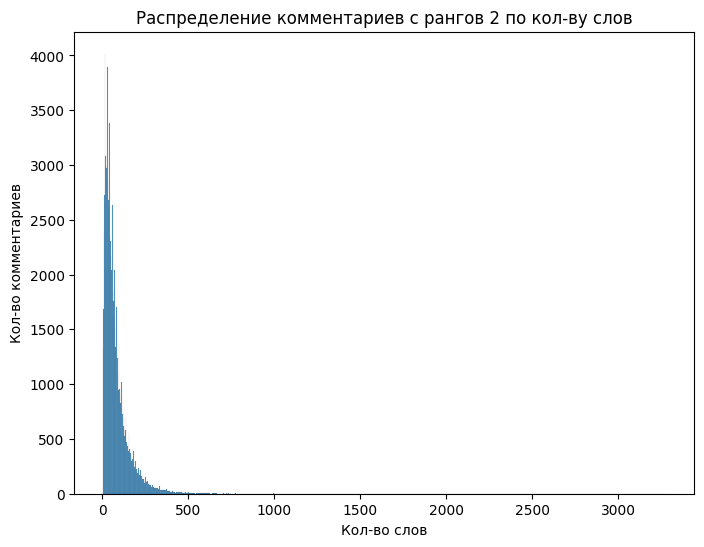

In [33]:
plt.figure(figsize = (8, 6))
(sns.histplot(train[train["score"] == 2]["comments_len"])
 .set(title='Распределение комментариев с рангов 2 по кол-ву слов', xlabel='Кол-во слов', ylabel='Кол-во комментариев')
)
plt.show()

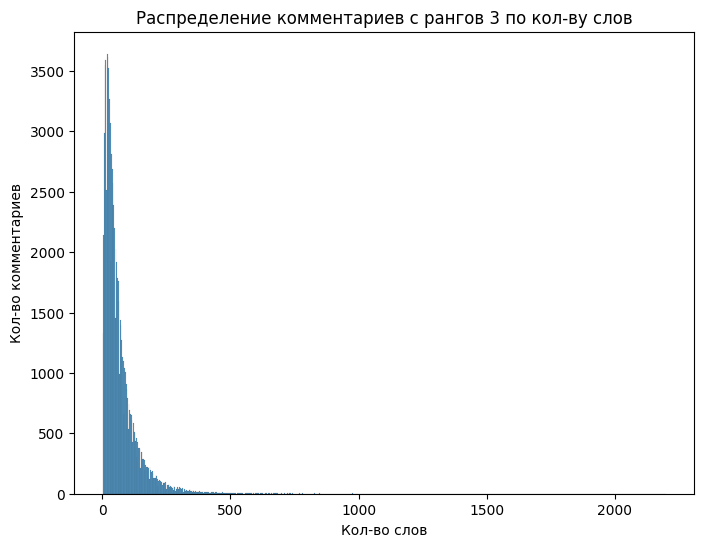

In [34]:
plt.figure(figsize = (8, 6))
(sns.histplot(train[train["score"] == 3]["comments_len"])
 .set(title='Распределение комментариев с рангов 3 по кол-ву слов', xlabel='Кол-во слов', ylabel='Кол-во комментариев')
)
plt.show()

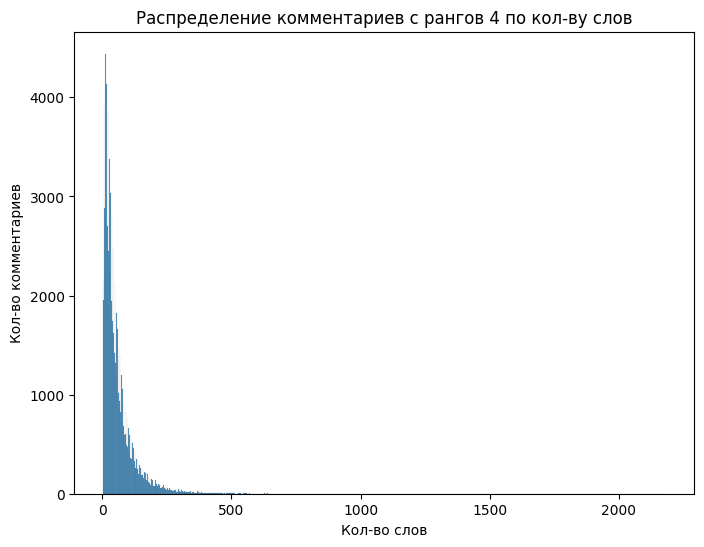

In [35]:
plt.figure(figsize = (8, 6))
(sns.histplot(train[train["score"] == 4]["comments_len"])
 .set(title='Распределение комментариев с рангов 4 по кол-ву слов', xlabel='Кол-во слов', ylabel='Кол-во комментариев')
)
plt.show()

Распределение комментариев с различными рангами по кол-ву слов по своей форме схожи между собой. Их кривая распределения напоминает кривую экспоненциального закона распределения.

Из этих графиков видно, вероятность получить комментарий с кол-во слов более 500 слишком мала. Конечно, этот порог к 500 слов для кадого ранга свой. Здесь 500 - это обобщённая оценка для всех рангов

Посмотрим на описательные статистики по длинам комментариев

In [36]:
train.groupby("score").agg(
    mean = ("comments_len", "mean"),
    median = ("comments_len", "median"),
    std = ("comments_len", "std"),
    min_ = ("comments_len", "min"),
    max_ = ("comments_len", "max"),
    percentile025 = ("comments_len", lambda x: np.quantile(x, 0.25)),
    percentile075 = ("comments_len", lambda x: np.quantile(x, 0.75)),
)

,mean,median,std,min_,max_,percentile025,percentile075
score,,,,,,,
0,141.181552,99.0,153.078555,1,10695,51.0,181.0
1,96.472914,67.0,100.157108,1,3565,35.0,124.0
2,77.678845,53.0,82.570818,1,3280,27.0,99.0
3,66.693838,44.0,73.641563,1,2200,22.0,85.0
4,57.975382,38.0,67.529733,1,2183,18.0,73.0


Здесь возникает гипотеза: описательные статисики и сама фича "длина комментария" могут быть релевантными для модели ранжирования

Эту гипотезу можно проверить с помощью HSD критерия Тьюки

Для начала посмотрим на боксплоты длин комментариев

In [37]:
group0 = train[train["score"] == 0]["comments_len"].values
group1 = train[train["score"] == 1]["comments_len"].values
group2 = train[train["score"] == 2]["comments_len"].values
group3 = train[train["score"] == 3]["comments_len"].values
group4 = train[train["score"] == 4]["comments_len"].values

assert group0.shape[0] == group1.shape[0] == group2.shape[0] == group3.shape[0] == group4.shape[0]

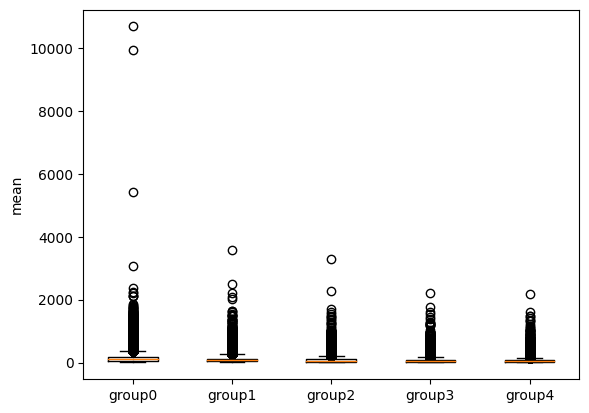

In [38]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([group0, group1, group2, group3, group4])
ax.set_xticklabels(["group0", "group1", "group2", "group3", "group4"]) 
ax.set_ylabel("mean") 
plt.show()

Видно, что в каждой группе присутствуют экстремальные значения - выбросы. Глазами различие в средних групп определить здесь сложно. Поэтому воспользуемся критерием Тьюки

In [39]:
print(tukey_hsd(group0, group1, group2, group3, group4))

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     44.709     0.000    43.406    46.012
 (0 - 2)     63.503     0.000    62.200    64.806
 (0 - 3)     74.488     0.000    73.185    75.791
 (0 - 4)     83.206     0.000    81.903    84.509
 (1 - 0)    -44.709     0.000   -46.012   -43.406
 (1 - 2)     18.794     0.000    17.491    20.097
 (1 - 3)     29.779     0.000    28.476    31.082
 (1 - 4)     38.498     0.000    37.194    39.801
 (2 - 0)    -63.503     0.000   -64.806   -62.200
 (2 - 1)    -18.794     0.000   -20.097   -17.491
 (2 - 3)     10.985     0.000     9.682    12.288
 (2 - 4)     19.703     0.000    18.400    21.007
 (3 - 0)    -74.488     0.000   -75.791   -73.185
 (3 - 1)    -29.779     0.000   -31.082   -28.476
 (3 - 2)    -10.985     0.000   -12.288    -9.682
 (3 - 4)      8.718     0.000     7.415    10.022
 (4 - 0)    -83.206     0.000   -84.509   -81.903
 (4 - 1)    -38.498     0.000   

По результатам теста видно, что средние в каждой группе отличаются. Это может означать, что длина комментария хороший признак

Посмотрим на самые часто встречаемые слова в постах и комментариях

In [40]:
tmp_lst = []
for text in tqdm(train["text"].unique()):
    tmp_lst += text.split()
    
text_words_count = Counter(tmp_lst)

del tmp_lst
gc.collect();

100%|███████████████████████████████████████████████████████████████████████| 87664/87664 [00:00<00:00, 1032000.70it/s]


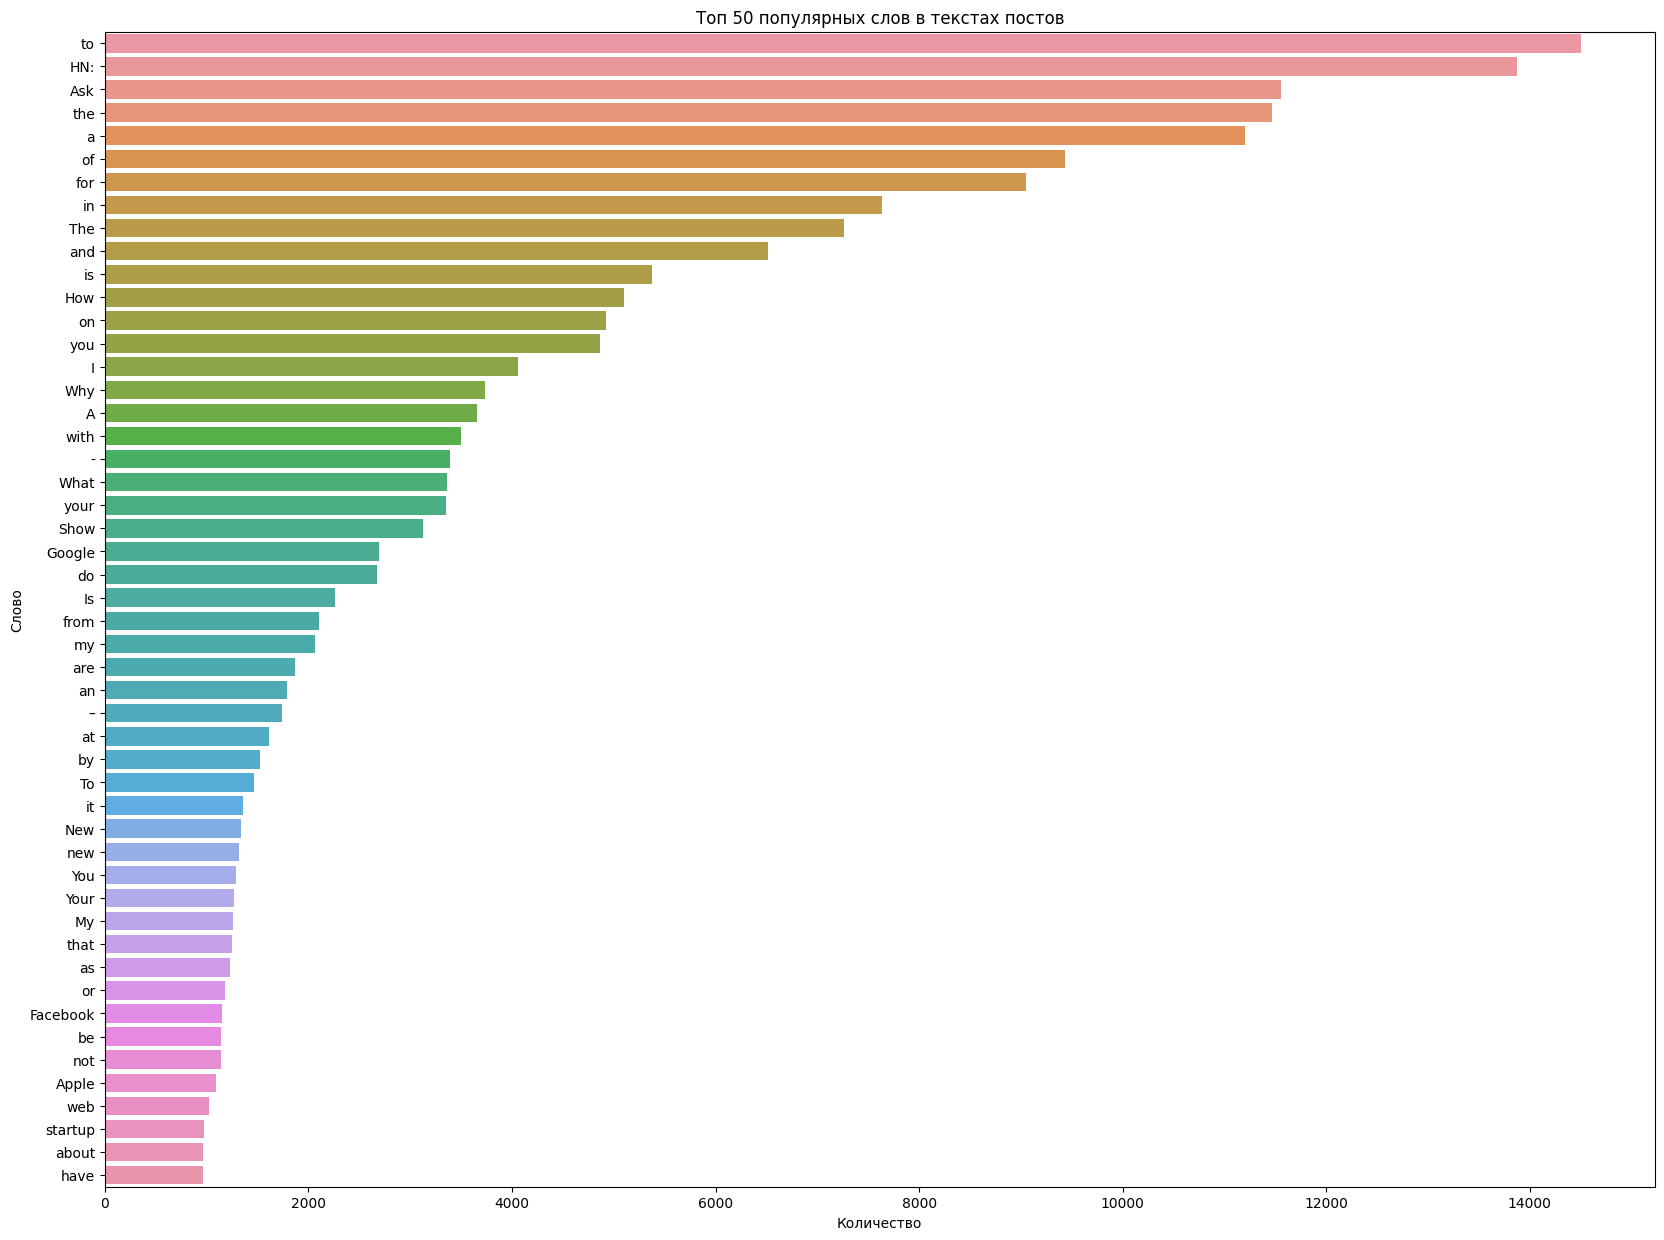

In [41]:
plt.figure(figsize=(20, 15))
plt.ticklabel_format(style='plain', axis='x')
(sns.barplot(
    y = list(map(lambda x: x[0], text_words_count.most_common(50))),
    x = list(map(lambda x: x[1], text_words_count.most_common(50)))
 ).set(title = "Топ 50 популярных слов в текстах постов", xlabel = "Количество", ylabel = "Слово")
)
plt.show()

Очевидно, что самыми популярными здесь являются служебные части речи: предлоги, артикли и т.д.  
Также можно заметить, что в постах присутствуют ответ какому пользователю "HN", а также знаки пунктуации, например, тире

In [42]:
tmp_lst = []
for text in tqdm(train["comments"].unique()):
    tmp_lst += text.split()
    
comments_words_count = Counter(tmp_lst)

del tmp_lst
gc.collect();

100%|██████████████████████████████████████████████████████████████████████| 440525/440525 [00:03<00:00, 125434.84it/s]


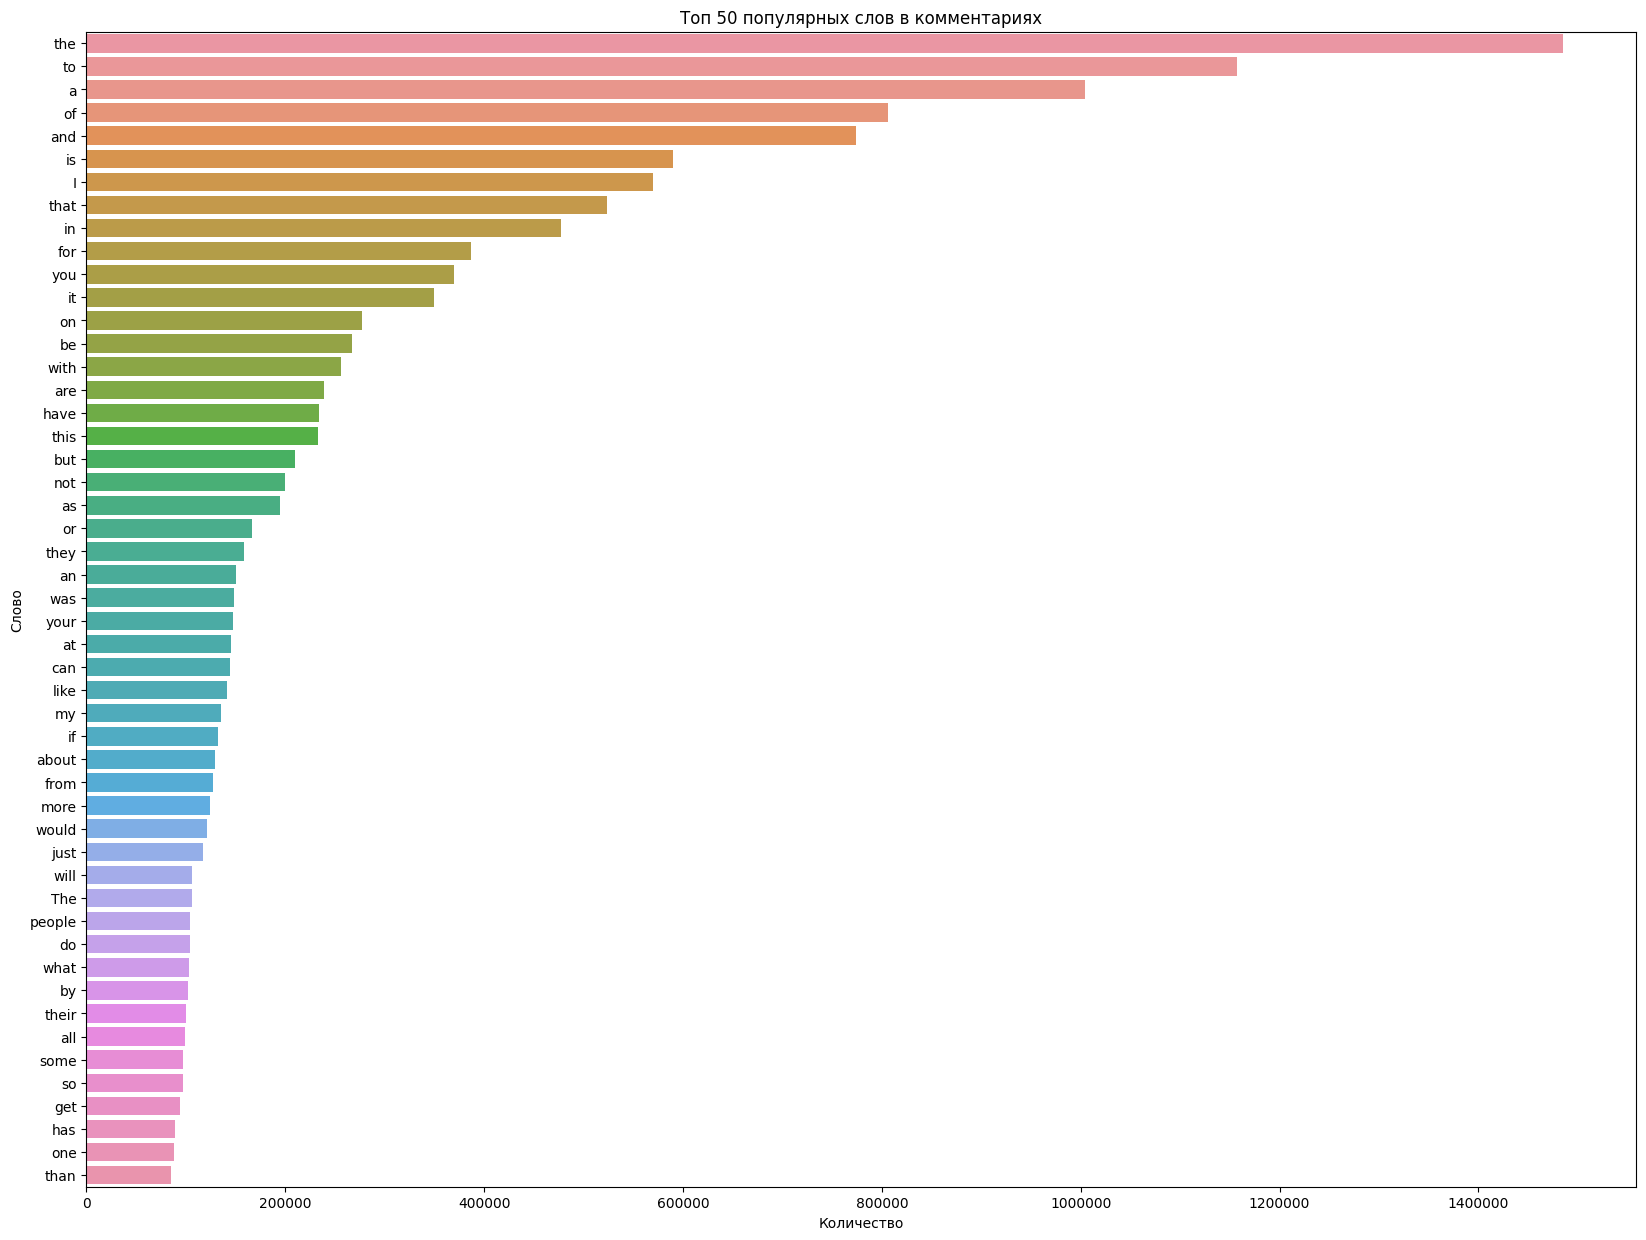

In [43]:
plt.figure(figsize=(20, 15))
plt.ticklabel_format(style='plain', axis='x')
(sns.barplot(
    y = list(map(lambda x: x[0], comments_words_count.most_common(50))),
    x = list(map(lambda x: x[1], comments_words_count.most_common(50)))
 ).set(title = "Топ 50 популярных слов в комментариях", xlabel = "Количество", ylabel = "Слово")
)
plt.show()

Аналогично и здесь. Самыми популярными являются служебные части речи

Если смотреть на взаимодействие слов, то, очевидно, что наиболее часто между собой будут взаимодействовать предлоги, артикли, цифры, символы пунктуации, а также непонятные слова, например, x2f

Посмотрим теперь на текст постов, в которые содержатся символы unicode

In [44]:
def get_emoji(data: str) -> str:
    """
    Gets string with unicode chars from input string
    :data: initial string
    "returns: string with unicode chars
    """
    emoj = re.compile(
        "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+",
        re.UNICODE
    )
    return ' '.join(re.findall(emoj, data))

In [45]:
train["text_emoji"] = train["text"].progress_apply(get_emoji)

100%|██████████████████████████████████████████████████████████████████████| 440535/440535 [00:01<00:00, 247579.09it/s]


In [46]:
train[train["text_emoji"] != '']["text"].unique()

array(['New Twitter Code For Retweet: ♺',
       'Ask HN: Review \ufeffClusterify.com - small coding project meetups - creators met on HN',
       '有中国的同胞吗？', 'GitHub Notiﬁcations: Stars, please',
       "Why aren't ◎ܫ◎ and ☺ valid Javascript variable names?",
       ' Mini-Seedcamp ✔ Scoble ✔ YC Interview ✔ YCW12 ✖ Launch Anyway ✔',
       'Unicode URL - ☃.net', '☑ Things 2',
       'Is the use of “utf8=✓” preferable to “utf8=true”?',
       'Nobody ever got ﬁred for buying a cluster',
       'Product ＞ Strategy ＞ Business Model ',
       'MAYHEM – automatically ﬁnding bugs and shell-spawning exploits in binaries [pdf]',
       'The ﹤main﹥ element', '☃',
       'The Marriage of Figaro… and Rails 4.1 👰',
       'Ask PG: Why not use the ▲ unicode character instead of a gif on HN?',
       '￼￼Intel Clang-based C++ Compiler [pdf]',
       'When AES(☢) = ☠ – a crypto-binary trick ',
       'A Uniﬁed Theory of Garbage Collection [pdf]', '🌉',
       'Tracking.js － A modern approach for compu

Сделаем тоже самое, но уже для комментариев

In [47]:
train["comments_emoji"] = train["comments"].progress_apply(get_emoji)

100%|███████████████████████████████████████████████████████████████████████| 440535/440535 [00:07<00:00, 62862.83it/s]


In [48]:
train[train["comments_emoji"] != '']["comments"]

13312     Best part: "There is a test for programming ap...
13519     Looking at the source code:- minimize CSS &#38...
18017     "... Your opinion on we♥places?  ..."Good but ...
20574         ❖Average 25% - 30% saving on engagements\n...
31727     I have to admit this is our first iPhone app a...
                                ...                        
437607    How are these results reconciled with well-doc...
438472    Just an update from the Google side: As discus...
438824    This piece claims to be an essay? Its very lig...
439847    I&#x27;m a Chinese software developer. In Chin...
440224    &gt; &quot;Netflix&#x27;s kind of late-1990s v...
Name: comments, Length: 395, dtype: object

Вывод отсюда простой: символы юникода надо фильтровать, а также все символы, которые начинаются на &, #, \ (\n, \t)